10.2.2 확률과정의 4번(점프 확산) 참고

In [1]:
import numpy as np
from sn_random_numbers import sn_random_numbers
from simulation_class import simulation_class

# 16.4.1 시뮬레이션 클래스

In [2]:
class jump_diffusion(simulation_class):
    ''' 머튼의 점프 확산 모형에 따른 시뮬레이션 경로를 생성하기 위한 클래스
    
    속성
    ====
    name : string
        객체 이름
    
    mar_env : instance of market_environment
        시뮬레이션에 필요한 시장 환경
    
    corr : Boolean
        다른 모형 객체와 상관관계가 있으면 True
    
    Method
    =======
    update : 
        파라미터 갱신
    
    generate_paths :
        주어진 시장 환경에 따른 몬테카를로 경로 반환
    '''
    
    def __init__(self, name, mar_env, corr = False):
        super(jump_diffusion, self).__init__(name, mar_env, corr)
        try:
            # 추가 파라미터 필요
            self.lamb = mar_env.get_constant('lambda')
            self.mu = mar_env.get_constant('mu')
            self.delt = mar_env.get_constant('delta')
        
        except:
            print('Error parsing market environment')
        
    def update(self, initial_value = None, volatility = None, lamb = None, mu = None, delta = None, final_date = None):
        if initial_value is not None:
            self.initial_value = initial_value
        
        if volatility is not None:
            self.volatility = volatility
        
        if lamb is not None:
            self.lamb = lamb
        
        if mu is not None:
            self.mu = mu
        
        if delta is not None:
            self.delt = delta
        
        if final_date is not None:
            self.final_date = final_date
            
        self.instrument_values = None

    def generate_paths(self, fixed_seed = False, day_count = 365.):
        if self.time_grid is None:
            self.generate_time_grid()
                # 일반적인 시뮬레이션 클래스 Method
        
        # 시간 그리드의 날짜 수
        M = len(self.time_grid)
        
        # 경로 수
        I = self.paths
        
        # 시뮬레이션에 필요한 배열 초기화
        paths = np.zeros((M, I))
        
        # initial_value로 처음 날짜에 해당하는 값 초기화
        paths[0] = self.initial_value
        
        if self.correlated is False:
            sn1 = sn_random_numbers((1, M, I), fixed_seed = fixed_seed)
        
        else:
            sn1 = self.random_numbers
        
        # 점프 요인에 필요한 표준정규분포 난수 생성
        sn2 = sn_random_numbers((1, M, I), fixed_seed = fixed_seed)
        
        rj = self.lamb * (np.exp(self.mu + 0.5 * self.delt ** 2) - 1)
        
        short_rate = self.discount_curve.short_rate
        for t in range(1, len(self.time_grid)):
            if self.correlated is False:
                ran = sn1[t]
            
            else:
                ran = np.dot(self.cholesky_matrix, sn1[:, t, :])
                ran = ran[self.rn_set]
            
            dt = (self.time_grid[t] - self.time_grid[t - 1]).days / day_count
            poi = np.random.poisson(self.lamb * dt, I)
                # 점프 요소에 필요한 포아송 분포 난수
            
            paths[t] = paths[t - 1] * (np.exp((short_rate - rj - 0.5 * self.volatility ** 2) * dt
                                              + self.volatility * np.sqrt(dt) * ran)
                                       + (np.exp(self.mu + self.delt * sn2[t]) - 1) * poi)
        self.instrument_values = paths
        

# 16.4.2 사용 예

In [3]:
from dx_frame import *

In [4]:
me_jd = market_environment('me_jd', dt.datetime(2015, 1, 1))

In [5]:
me_jd.add_constant('lambda', 0.3)
me_jd.add_constant('mu', -0.75)
me_jd.add_constant('delta', 0.1)

#### 16.3(기하 브라운 운동)에서 정의된 market_environment 이용

In [6]:
from geometric_brownian_motion import geometric_brownian_motion

In [7]:
me_gbm = market_environment('me_gbm', dt.datetime(2015, 1, 1))
me_gbm.add_constant('initial_value', 36.)
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('final_date', dt.datetime(2015, 12, 31))
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('frequency', 'M')
me_gbm.add_constant('paths', 10000)

In [8]:
csr = constant_short_rate('csr', 0.05)
me_gbm.add_curve('discount_curve', csr)
gbm = geometric_brownian_motion('gbm', me_gbm)

In [9]:
me_jd.add_environment(me_gbm)

In [10]:
jd = jump_diffusion('jd', me_jd)

In [11]:
%time paths_3 = jd.get_instrument_values()

Wall time: 26.9 ms


In [12]:
jd.update(lamb = 0.9)

In [13]:
%time paths_4 = jd.get_instrument_values()

Wall time: 22.1 ms


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
gbm.generate_time_grid()

In [16]:
gbm.time_grid

array([datetime.datetime(2015, 1, 1, 0, 0),
       datetime.datetime(2015, 1, 31, 0, 0),
       datetime.datetime(2015, 2, 28, 0, 0),
       datetime.datetime(2015, 3, 31, 0, 0),
       datetime.datetime(2015, 4, 30, 0, 0),
       datetime.datetime(2015, 5, 31, 0, 0),
       datetime.datetime(2015, 6, 30, 0, 0),
       datetime.datetime(2015, 7, 31, 0, 0),
       datetime.datetime(2015, 8, 31, 0, 0),
       datetime.datetime(2015, 9, 30, 0, 0),
       datetime.datetime(2015, 10, 31, 0, 0),
       datetime.datetime(2015, 11, 30, 0, 0),
       datetime.datetime(2015, 12, 31, 0, 0)], dtype=object)

(array([16436., 16495., 16556., 16617., 16679., 16740., 16801.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

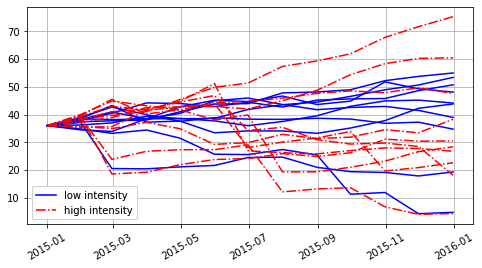

In [17]:
plt.figure(figsize = (8,4))
p1 = plt.plot(gbm.time_grid, paths_3[:, :10], 'b')
p2 = plt.plot(gbm.time_grid, paths_4[:, :10], 'r-.')
plt.grid(True)
l1 = plt.legend([p1[0], p2[0]], ['low intensity', 'high intensity'], loc = 3)
plt.gca().add_artist(l1)
plt.xticks(rotation = 30)
